In [1]:
!nvidia-smi

Fri May 30 05:45:29 2025       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  On   | 00000000:C1:00.0 Off |                    0 |
| N/A   38C    P0    50W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader, random_split, ConcatDataset, Subset
import torchaudio
import torchaudio.transforms as T
import torch.nn as nn
from transformers import WhisperProcessor, WhisperModel
import copy
import random

In [3]:
# ----- Config -----
# nectec/Pathumma-whisper-th-large-v3
# openai/whisper-large
# biodatlab/whisper-th-large-v3-combined
MODEL_NAME = "./Model_whisper/"
NUM_LABELS = 6
BATCH_SIZE = 8
EPOCHS = 30
LEARNING_RATE = 1e-4
SAMPLING_RATE = 16000
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

processor = WhisperProcessor.from_pretrained(MODEL_NAME)
whisper_model = WhisperModel.from_pretrained(MODEL_NAME)

In [4]:
# ----- Model Definition -----
class WhisperClassifier(nn.Module):
    def __init__(self, whisper_model=whisper_model, num_labels=NUM_LABELS):
        super().__init__()
        self.encoder = whisper_model.encoder
        self.encoder_block = nn.TransformerEncoder(
                        nn.TransformerEncoderLayer(d_model=1280, nhead=8, dropout=0.1, batch_first=True, activation='gelu'),
                        num_layers=2
                        )
        self.classifier = nn.Sequential(
            nn.Linear(1280, num_labels),
        )
        self.weight_proj = nn.Linear(1280, 1)

    def forward(self, input_features_1, input_features_2):
        outputs_1 = self.encoder(input_features=input_features_1).last_hidden_state
        outputs_2 = self.encoder(input_features=input_features_2).last_hidden_state
        cat_outputs = torch.cat([outputs_1, outputs_2], dim=1)
        x_attn = self.encoder_block(cat_outputs)
        weights = torch.softmax(self.weight_proj(x_attn), dim=1)
        pooled = (x_attn * weights).sum(dim=1)
        logits = self.classifier(pooled)
        return logits

In [5]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha  # controls class imbalance
        self.gamma = gamma  # focuses on hard examples
        self.reduction = reduction

    def forward(self, inputs, targets):
        # Calculate Binary Cross-Entropy Loss for each sample
        BCE_loss = nn.functional.binary_cross_entropy_with_logits(inputs, targets, reduction='none')

        # Compute pt (model confidence on true class)
        pt = torch.exp(-BCE_loss)

        # Apply the focal adjustment
        focal_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss

        # Apply reduction (mean, sum, or no reduction)
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

In [6]:
# ----- Dataset Definition -----
class WhisperMultilabelDataset(Dataset):
    def __init__(self, csv_path, audio_dir, label_columns, processor, sampling_rate=16000):
        self.df = pd.read_csv(csv_path)
        self.audio_dir = audio_dir
        self.label_columns = label_columns
        self.processor = processor
        self.sampling_rate = sampling_rate

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        audio_path = os.path.join(self.audio_dir, row['id'] + '.wav')
        waveform, sr = torchaudio.load(audio_path)

        if sr != self.sampling_rate:
            waveform = T.Resample(orig_freq=sr, new_freq=self.sampling_rate)(waveform)

        waveform = waveform.squeeze(0)
        if waveform.dim() == 2:
            waveform = torch.mean(waveform, dim=0)
        chunck_lst = []
        for num_chuck in range(2):
            inputs = self.processor(waveform[num_chuck * 480000:(num_chuck+1) * 480000], sampling_rate=self.sampling_rate, return_tensors="pt")
            input_features = inputs.input_features.squeeze(0)
            chunck_lst.append(input_features)
        #inputs = self.processor(waveform, sampling_rate=self.sampling_rate, return_tensors="pt")
        #input_features = inputs.input_features.squeeze(0)

        labels = torch.tensor(row[self.label_columns].astype(int).values, dtype=torch.float32)
        return {"input_features_1": chunck_lst[0], "input_features_2": chunck_lst[1], "labels": labels}

#----- Usage Example -----
label_columns = [
    'กล่าวสวัสดี',
    'แนะนำชื่อและนามสกุล',
    'บอกประเภทใบอนุญาตและเลขที่ใบอนุญาตที่ยังไม่หมดอายุ',
    'บอกวัตถุประสงค์ของการเข้าพบครั้งนี้',
    'เน้นประโยชน์ว่าลูกค้าได้ประโยชน์อะไรจากการเข้าพบครั้งนี้',
    'บอกระยะเวลาที่ใช้ในการเข้าพบ'
]


In [7]:
model = WhisperClassifier(num_labels=NUM_LABELS).to(DEVICE)

# ----- Optimizer & Loss -----
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
#criterion = nn.BCEWithLogitsLoss()
criterion = FocalLoss(alpha=1, gamma=2)


import re

pattern = r'\.(30|31)\.'

for layer, param in model.encoder.named_parameters():
    if re.search(pattern, layer):
        param.requires_grad = True
    else:
        param.requires_grad = False

In [8]:
dataset = WhisperMultilabelDataset("./data_asr/train.csv", "./data_asr/speechs/speechs/train/", label_columns, processor)
dataset_gen = WhisperMultilabelDataset("./data_asr/labeled_train.csv", "./data_asr/speechs/speechs/gen/speech/", label_columns, processor)

full_dataset = ConcatDataset([dataset, dataset_gen])
total_size = len(full_dataset)
indices = list(range(total_size))
random.seed(42)
random.shuffle(indices)

train_size = int(0.8 * total_size)
train_indices = indices[:train_size]
val_indices = indices[train_size:]

train_dataset = Subset(full_dataset, train_indices)
val_dataset = Subset(full_dataset, val_indices)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [9]:
dataset = WhisperMultilabelDataset("./data_asr/train.csv", "./data_asr/speechs/speechs/train/", label_columns, processor)
dataset_gen = WhisperMultilabelDataset("./data_asr/labeled_train.csv", "./data_asr/speechs/speechs/gen/speech/", label_columns, processor)

full_dataset = ConcatDataset([dataset, dataset_gen])

# Split dataset into train and val
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
torch.manual_seed(42)
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [10]:
from tqdm import tqdm

best_val_loss = float('inf')
best_model_path = 'best_model.pt' 

# ----- Training Loop -----
for epoch in tqdm(range(EPOCHS)):
    total_loss = 0
    val_loss = 0
    model.train()
    for batch in train_loader:
        input_features_1 = batch['input_features_1'].to(DEVICE)
        input_features_2 = batch['input_features_2'].to(DEVICE)
        labels = batch['labels'].to(DEVICE)

        logits = model(input_features_1, input_features_2)
        loss = criterion(logits, labels)

        loss.backward()
        optimizer.step()
        #scheduler.step()
        optimizer.zero_grad()
        total_loss += loss.item()
    avg_train_loss = total_loss / len(train_loader)

    if epoch % 2 == 0:
        model.eval()
        with torch.no_grad():
            for batch in val_loader:
                input_features_1 = batch['input_features_1'].to(DEVICE)
                input_features_2 = batch['input_features_2'].to(DEVICE)
                labels = batch['labels'].to(DEVICE)

                logits = model(input_features_1, input_features_2)
                loss = criterion(logits, labels)
                val_loss += loss.item()
        avg_val_loss = val_loss / len(val_loader)
        print(f"Epoch {epoch+1}: Training Loss = {avg_train_loss:.4f} , Validation Loss = {avg_val_loss:.4f}")
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), best_model_path)
            print(f"Saved new best model with val_loss = {avg_val_loss:.4f}")


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1: Training Loss = 0.4114 , Validation Loss = 0.2335


  3%|▎         | 1/30 [00:38<18:48, 38.91s/it]

Saved new best model with val_loss = 0.2335


  7%|▋         | 2/30 [01:06<15:00, 32.15s/it]

Epoch 3: Training Loss = 0.1761 , Validation Loss = 0.1849


 10%|█         | 3/30 [01:44<15:37, 34.71s/it]

Saved new best model with val_loss = 0.1849


 13%|█▎        | 4/30 [02:11<13:47, 31.82s/it]

Epoch 5: Training Loss = 0.1438 , Validation Loss = 0.1409


 17%|█▋        | 5/30 [02:49<14:08, 33.95s/it]

Saved new best model with val_loss = 0.1409


 20%|██        | 6/30 [03:16<12:41, 31.72s/it]

Epoch 7: Training Loss = 0.1043 , Validation Loss = 0.1110


 23%|██▎       | 7/30 [03:54<12:54, 33.66s/it]

Saved new best model with val_loss = 0.1110


 27%|██▋       | 8/30 [04:21<11:36, 31.67s/it]

Epoch 9: Training Loss = 0.0693 , Validation Loss = 0.0969


 30%|███       | 9/30 [04:59<11:44, 33.55s/it]

Saved new best model with val_loss = 0.0969


 37%|███▋      | 11/30 [05:59<10:08, 32.01s/it]

Epoch 11: Training Loss = 0.0412 , Validation Loss = 0.1544


 40%|████      | 12/30 [06:26<09:10, 30.59s/it]

Epoch 13: Training Loss = 0.0342 , Validation Loss = 0.0878


 43%|████▎     | 13/30 [07:04<09:16, 32.74s/it]

Saved new best model with val_loss = 0.0878


 50%|█████     | 15/30 [08:04<07:54, 31.64s/it]

Epoch 15: Training Loss = 0.0132 , Validation Loss = 0.1298


 57%|█████▋    | 17/30 [09:05<06:44, 31.10s/it]

Epoch 17: Training Loss = 0.0046 , Validation Loss = 0.1196


 63%|██████▎   | 19/30 [10:05<05:39, 30.84s/it]

Epoch 19: Training Loss = 0.0013 , Validation Loss = 0.1235


 70%|███████   | 21/30 [11:05<04:36, 30.71s/it]

Epoch 21: Training Loss = 0.0005 , Validation Loss = 0.1401


 77%|███████▋  | 23/30 [12:05<03:34, 30.64s/it]

Epoch 23: Training Loss = 0.0002 , Validation Loss = 0.1391


 83%|████████▎ | 25/30 [13:05<02:33, 30.61s/it]

Epoch 25: Training Loss = 0.0002 , Validation Loss = 0.1390


 90%|█████████ | 27/30 [14:05<01:31, 30.59s/it]

Epoch 27: Training Loss = 0.0001 , Validation Loss = 0.1421


 97%|█████████▋| 29/30 [15:06<00:30, 30.59s/it]

Epoch 29: Training Loss = 0.0001 , Validation Loss = 0.1454


100%|██████████| 30/30 [15:33<00:00, 31.12s/it]


In [11]:
model.load_state_dict(torch.load("best_model_2trans.pt", weights_only=True))

<All keys matched successfully>

/home/ai5123/.conda/envs/three_exp/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ai5123/.conda/envs/three_exp/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ai5123/.conda/envs/three_exp/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize

F2 Score: 0.9313
Precision: 0.9065
Recall: 0.9457


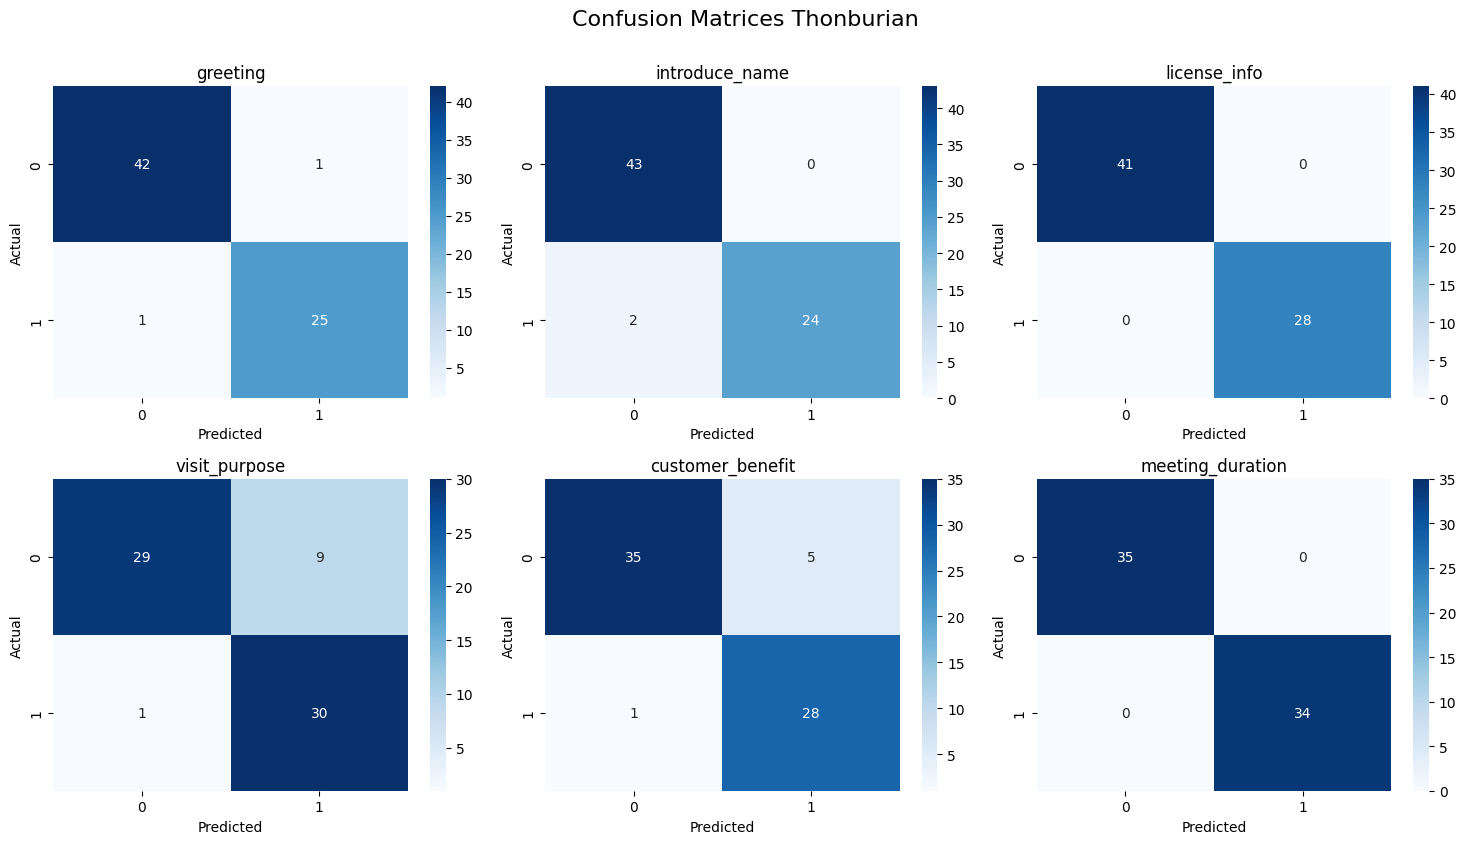

In [34]:
# Evaluation using F2 Score, Precision, Recall and Confusion Matrix

import torch
import numpy as np
from sklearn.metrics import fbeta_score, precision_score, recall_score, multilabel_confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

THRESHOLD = 0.4
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in val_loader:
        input_features_1 = batch['input_features_1'].to(DEVICE)
        input_features_2 = batch['input_features_2'].to(DEVICE)
        labels = batch['labels'].cpu().numpy()
        logits = model(input_features_1, input_features_2)
        probs = torch.sigmoid(logits).cpu().numpy()
        preds = (probs > THRESHOLD).astype(int)

        all_preds.append(preds)
        all_labels.append(labels)

all_preds = np.concatenate(all_preds, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

# Metric calculation
f2 = fbeta_score(all_labels, all_preds, beta=2, average='samples')
precision = precision_score(all_labels, all_preds, average='samples')
recall = recall_score(all_labels, all_preds, average='samples')

print(f"F2 Score: {f2:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

#Confusion matrix per label (combined in one figure)
label_columns_en = [
    "greeting",
    "introduce_name",
    "license_info",
    "visit_purpose",
    "customer_benefit",
    "meeting_duration"
]

# label_columns_en = [
#     "customer_benefit",
# ]

cm = multilabel_confusion_matrix(all_labels, all_preds)
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
for i, (ax, label) in enumerate(zip(axes.flat, label_columns_en)):
    sns.heatmap(cm[i], annot=True, fmt="d", cmap="Blues", ax=ax)
    ax.set_title(f"{label}")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")

plt.tight_layout()
plt.suptitle("Confusion Matrices Thonburian", fontsize=16, y=1.05)
plt.show()

In [32]:
# Inference on Test Set and Output CSV with Boolean Labels

import pandas as pd
import torch
import torchaudio
from torch.utils.data import Dataset, DataLoader
from transformers import WhisperProcessor

class WhisperTestDataset(Dataset):
    def __init__(self, csv_path, audio_dir, processor, sampling_rate=16000):
        self.df = pd.read_csv(csv_path)
        self.audio_dir = audio_dir
        self.processor = processor
        self.sampling_rate = sampling_rate

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        audio_path = os.path.join(self.audio_dir, row['id'] + '.wav')
        waveform, sr = torchaudio.load(audio_path)
        if sr != self.sampling_rate:
            waveform = torchaudio.transforms.Resample(orig_freq=sr, new_freq=self.sampling_rate)(waveform)
        waveform = waveform.squeeze(0)
        chunck_lst = []
        for num_chuck in range(2):
            inputs = self.processor(waveform[num_chuck * 480000:(num_chuck+1) * 480000], sampling_rate=self.sampling_rate, return_tensors="pt")
            input_features = inputs.input_features.squeeze(0)
            chunck_lst.append(input_features)
        #inputs = self.processor(waveform, sampling_rate=self.sampling_rate, return_tensors="pt")
        #input_features = inputs.input_features.squeeze(0)
        return row['id'], {"input_features_1": chunck_lst[0], "input_features_2": chunck_lst[1]}

# Config
TEST_CSV_PATH = "./data_asr/test.csv"
TEST_AUDIO_DIR = "./data_asr/speechs/speechs/test/"
THRESHOLD = 0.4

# Load
#processor = WhisperProcessor.from_pretrained(MODEL_NAME)
test_dataset = WhisperTestDataset(TEST_CSV_PATH, TEST_AUDIO_DIR, processor, sampling_rate=SAMPLING_RATE)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Inference
model.eval()
results = []

with torch.no_grad():
    for audio_id, input_features in tqdm(test_loader):
        input_features_1 = input_features['input_features_1'].to(DEVICE)
        input_features_2 = input_features['input_features_2'].to(DEVICE)
        logits = model(input_features_1, input_features_2)
        probs = torch.sigmoid(logits).cpu().numpy()
        preds = (probs > THRESHOLD).astype(bool).tolist()[0]
        results.append([audio_id[0]] + preds)

# Save to CSV
label_columns = [
    'กล่าวสวัสดี',
    'แนะนำชื่อและนามสกุล',
    'บอกประเภทใบอนุญาตและเลขที่ใบอนุญาตที่ยังไม่หมดอายุ',
    'บอกวัตถุประสงค์ของการเข้าพบครั้งนี้',
    'เน้นประโยชน์ว่าลูกค้าได้ประโยชน์อะไรจากการเข้าพบครั้งนี้',
    'บอกระยะเวลาที่ใช้ในการเข้าพบ'
]

columns = ['id'] + label_columns
submission_df = pd.DataFrame(results, columns=columns)

100%|██████████| 300/300 [01:33<00:00,  3.20it/s]


In [33]:
submission_df.to_csv("submission_add_data_04.csv", index=False)
print("Saved submission.csv")

Saved submission.csv
